<a href="https://colab.research.google.com/github/Narennnnn/bilingual-word-align/blob/main/CrossLingualWordEmbeddingsModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Required Libraries Installation
!pip install gensim numpy scipy scikit-learn faiss-cpu

import numpy as np
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics.pairwise import cosine_similarity
import faiss
import multiprocessing as mp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 20.4 MB/s eta 0:00:00


In [2]:

# ======================================
# Step 1: Data Preparation
# ======================================

# Download pre-trained FastText embeddings (English and Hindi)
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.hi.vec

def load_vectors_optimized(filename, limit=100000, dtype=np.float16):
    """
    Load pre-trained FastText embeddings with memory optimization.

    :param filename: Path to the FastText vector file
    :param limit: Limit the number of vectors to load (default is 100,000)
    :param dtype: Data type for storing vectors (default is np.float16)
    :return: Dictionary with words as keys and vectors as values
    """
    vectors = {}
    with open(filename, 'r', encoding='utf-8') as f:
        next(f)  # Skip the first line (header)
        for i, line in enumerate(f):
            if i >= limit:
                break
            values = line.rstrip().split(' ')
            word = values[0]
            vector = np.asarray(values[1:], dtype=dtype)
            vectors[word] = vector
    return vectors

# Load English and Hindi embeddings
en_vectors = load_vectors_optimized('wiki.en.vec')
hi_vectors = load_vectors_optimized('wiki.hi.vec')

--2024-09-25 08:07:59--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.136.8, 18.238.136.37, 18.238.136.120, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.136.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6597238061 (6.1G) [binary/octet-stream]
Saving to: ‘wiki.en.vec’

wiki.en.vec         100%[===================>]   6.14G  98.6MB/s    in 67s     

2024-09-25 08:09:06 (94.0 MB/s) - ‘wiki.en.vec’ saved [6597238061/6597238061]

--2024-09-25 08:09:07--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.hi.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.136.120, 18.238.136.52, 18.238.136.8, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.136.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 416644179 (397M) [binary/octet-stream]
Saving to: ‘wiki.hi.vec’

wiki.hi.v

In [3]:
# Download MUSE bilingual lexicon
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.txt

def load_lexicon(filename, src_vectors, tgt_vectors):
    """
    Load the bilingual lexicon, ensuring words exist in both source and target vectors.

    :param filename: Path to the lexicon file
    :param src_vectors: Source language vector dictionary
    :param tgt_vectors: Target language vector dictionary
    :return: List of tuples representing bilingual lexicon pairs
    """
    lexicon = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            src_word, tgt_word = line.strip().split()
            if src_word in src_vectors and tgt_word in tgt_vectors:
                lexicon.append((src_word, tgt_word))
    return lexicon

bilingual_lexicon = load_lexicon('en-hi.txt', en_vectors, hi_vectors)

--2024-09-25 08:15:19--  https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.136.52, 18.238.136.8, 18.238.136.120, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.136.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930856 (909K) [text/x-c++]
Saving to: ‘en-hi.txt’

en-hi.txt           100%[===================>] 909.04K  --.-KB/s    in 0.06s   

2024-09-25 08:15:20 (14.6 MB/s) - ‘en-hi.txt’ saved [930856/930856]



In [4]:
# ======================================
# Step 2: Embedding Alignment using Procrustes Method
# ======================================

def align_embeddings(src_vectors, tgt_vectors, lexicon):
    """
    Perform embedding alignment using the Orthogonal Procrustes method.

    :param src_vectors: Source language vector dictionary
    :param tgt_vectors: Target language vector dictionary
    :param lexicon: Bilingual lexicon list
    :return: Alignment matrix (W)
    """
    src_mat = np.array([src_vectors[word] for word, _ in lexicon])
    tgt_mat = np.array([tgt_vectors[word] for _, word in lexicon])
    W, _ = orthogonal_procrustes(src_mat, tgt_mat)
    return W

alignment_matrix = align_embeddings(en_vectors, hi_vectors, bilingual_lexicon)

In [5]:
# ======================================
# Step 3: Fast Nearest Neighbor Search with Faiss
# ======================================

def build_faiss_index(vectors):
    """
    Build a FAISS index for fast nearest neighbor search.

    :param vectors: Vector dictionary
    :return: FAISS index and list of target words
    """
    dimension = len(next(iter(vectors.values())))
    index = faiss.IndexFlatIP(dimension)  # Inner product for cosine similarity
    vector_list = np.array(list(vectors.values())).astype('float32')
    faiss.normalize_L2(vector_list)  # Normalize vectors for cosine similarity
    index.add(vector_list)
    return index, list(vectors.keys())

tgt_index, tgt_words = build_faiss_index(hi_vectors)

def translate_word_faiss(word, src_vectors, alignment_matrix, index, tgt_words, k=5):
    """
    Translate a word using the FAISS index and return the top-k translations.

    :param word: Source word to be translated
    :param src_vectors: Source language vector dictionary
    :param alignment_matrix: Alignment matrix from Procrustes method
    :param index: FAISS index object
    :param tgt_words: List of target words
    :param k: Number of top translations to return (default is 5)
    :return: List of top-k translated words
    """
    if word not in src_vectors:
        return []
    src_vec = src_vectors[word].astype('float32')
    aligned_vec = np.dot(src_vec, alignment_matrix)
    faiss.normalize_L2(aligned_vec.reshape(1, -1))
    _, indices = index.search(aligned_vec.reshape(1, -1), k)
    return [tgt_words[i] for i in indices[0]]

In [6]:
# ======================================
# Step 4: Evaluation
# ======================================

# Download MUSE test dictionary
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.5000-6500.txt
test_lexicon = load_lexicon('en-hi.5000-6500.txt', en_vectors, hi_vectors)

def evaluate_translation_faiss(test_lexicon, src_vectors, alignment_matrix, index, tgt_words):
    """
    Evaluate the translation accuracy using the test lexicon.

    :param test_lexicon: List of test bilingual lexicon pairs
    :param src_vectors: Source language vector dictionary
    :param alignment_matrix: Alignment matrix from Procrustes method
    :param index: FAISS index object
    :param tgt_words: List of target words
    :return: Precision@1 and Precision@5 scores
    """
    correct_1, correct_5, total = 0, 0, len(test_lexicon)

    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.starmap(translate_word_faiss, [(src_word, src_vectors, alignment_matrix, index, tgt_words) for src_word, _ in test_lexicon])

    for i, (src_word, tgt_word) in enumerate(test_lexicon):
        translations = results[i]
        if translations:
            if translations[0] == tgt_word:
                correct_1 += 1
            if tgt_word in translations:
                correct_5 += 1

    precision_1 = correct_1 / total
    precision_5 = correct_5 / total
    return precision_1, precision_5

# Evaluate the model
precision_1, precision_5 = evaluate_translation_faiss(test_lexicon, en_vectors, alignment_matrix, tgt_index, tgt_words)
print(f"Precision@1: {precision_1:.4f}")
print(f"Precision@5: {precision_5:.4f}")

--2024-09-25 08:17:24--  https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.5000-6500.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.136.37, 18.238.136.52, 18.238.136.120, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.136.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52464 (51K) [text/plain]
Saving to: ‘en-hi.5000-6500.txt’

en-hi.5000-6500.txt 100%[===================>]  51.23K  --.-KB/s    in 0.01s   

2024-09-25 08:17:25 (4.38 MB/s) - ‘en-hi.5000-6500.txt’ saved [52464/52464]

Precision@1: 0.2569
Precision@5: 0.4583


In [7]:

# ======================================
# Analyze Cosine Similarities
# ======================================

def analyze_cosine_similarities(word_pairs, src_vectors, tgt_vectors, alignment_matrix):
    """
    Analyze cosine similarities between aligned source vectors and target vectors.

    :param word_pairs: List of word pairs to analyze
    :param src_vectors: Source language vector dictionary
    :param tgt_vectors: Target language vector dictionary
    :param alignment_matrix: Alignment matrix from Procrustes method
    :return: List of tuples containing word pairs and their cosine similarity
    """
    results = []
    for src_word, tgt_word in word_pairs:
        if src_word in src_vectors and tgt_word in tgt_vectors:
            src_vec = src_vectors[src_word]
            tgt_vec = tgt_vectors[tgt_word]
            aligned_src_vec = np.dot(src_vec, alignment_matrix)
            similarity = cosine_similarity([aligned_src_vec], [tgt_vec])[0][0]
            results.append((src_word, tgt_word, similarity))
    return results

word_pairs = [
    ('man', 'आदमी'),
    ('woman', 'औरत'),
    ('king', 'राजा'),
    ('queen', 'रानी'),
    ('cat', 'बिल्ली'),
    ('dog', 'कुत्ता')
]

similarity_results = analyze_cosine_similarities(word_pairs, en_vectors, hi_vectors, alignment_matrix)
for src_word, tgt_word, similarity in similarity_results:
    print(f"{src_word} - {tgt_word}: {similarity:.4f}")


man - आदमी: 0.5275
woman - औरत: 0.5964
king - राजा: 0.6152
queen - रानी: 0.5915
cat - बिल्ली: 0.5074
dog - कुत्ता: 0.6636


In [10]:
# ======================================
# Ablation Study
# ======================================

def ablation_study(src_vectors, tgt_vectors, full_lexicon, test_lexicon, sizes=[5000, 10000, 20000]):
    """
    Perform an ablation study to assess performance with varying lexicon sizes.

    :param src_vectors: Source language vector dictionary
    :param tgt_vectors: Target language vector dictionary
    :param full_lexicon: Full bilingual lexicon list
    :param test_lexicon: Test bilingual lexicon list
    :param sizes: List of lexicon sizes to evaluate
    :return: List of tuples containing lexicon size, precision@1, and precision@5
    """
    results = []
    for size in sizes:
        # Select a subset of the bilingual lexicon based on the current size
        train_lexicon = full_lexicon[:size]

        # Perform embedding alignment using the Procrustes method
        alignment_matrix = align_embeddings(src_vectors, tgt_vectors, train_lexicon)

        # Evaluate the translation accuracy using FAISS
        precision_1, precision_5 = evaluate_translation_faiss(test_lexicon, src_vectors, alignment_matrix, tgt_index, tgt_words)

        # Store the results for the current lexicon size
        results.append((size, precision_1, precision_5))

        print(f"Lexicon size: {size}, Precision@1: {precision_1:.4f}, Precision@5: {precision_5:.4f}")

    return results

# Run the ablation study
ablation_results = ablation_study(en_vectors, hi_vectors, bilingual_lexicon, test_lexicon)

# Display the results
for size, p1, p5 in ablation_results:
    print(f"Lexicon size: {size}, Precision@1: {p1:.4f}, Precision@5: {p5:.4f}")


Lexicon size: 5000, Precision@1: 0.1740, Precision@5: 0.3469
Lexicon size: 10000, Precision@1: 0.2823, Precision@5: 0.4715
Lexicon size: 20000, Precision@1: 0.2701, Precision@5: 0.4730
Lexicon size: 5000, Precision@1: 0.1740, Precision@5: 0.3469
Lexicon size: 10000, Precision@1: 0.2823, Precision@5: 0.4715
Lexicon size: 20000, Precision@1: 0.2701, Precision@5: 0.4730


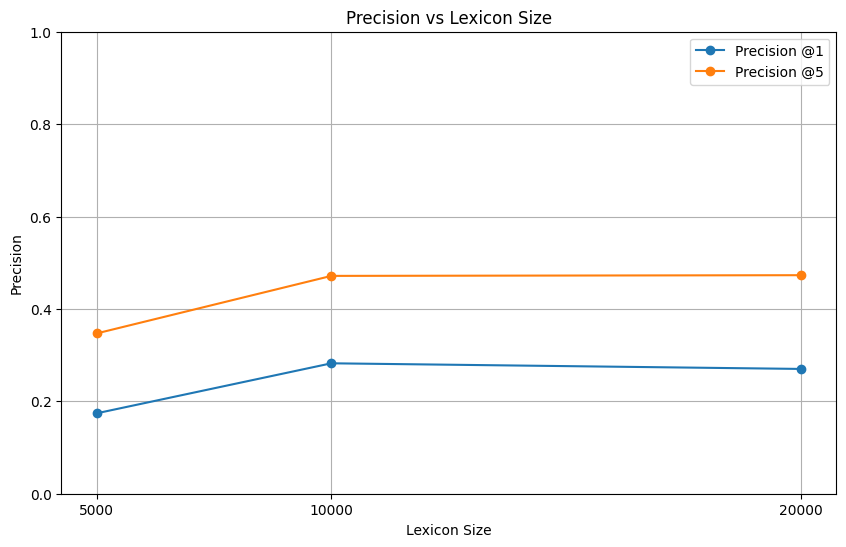

In [11]:
import matplotlib.pyplot as plt

# Data
lexicon_sizes = [5000, 10000, 20000]
precision_1 = [0.1740, 0.2823, 0.2701]
precision_5 = [0.3469, 0.4715, 0.4730]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(lexicon_sizes, precision_1, marker='o', label='Precision @1')
plt.plot(lexicon_sizes, precision_5, marker='o', label='Precision @5')

plt.title('Precision vs Lexicon Size')
plt.xlabel('Lexicon Size')
plt.ylabel('Precision')
plt.xticks(lexicon_sizes)
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.show()


In [22]:
def translate_example(word, src_vectors, alignment_matrix, index, tgt_words, k=2):
    """
    Translate a single word from English to Hindi using the trained model.

    :param word: The English word to be translated
    :param src_vectors: Source language vector dictionary (English)
    :param alignment_matrix: Alignment matrix from Procrustes method
    :param index: FAISS index object for target language (Hindi)
    :param tgt_words: List of target words (Hindi)
    :param k: Number of top translations to return
    :return: List of top-k translated words in Hindi
    """
    translations = translate_word_faiss(word, src_vectors, alignment_matrix, index, tgt_words, k)
    return translations

test_words = [
    'woman', 'king', 'queen', 'cat', 'dog',
    'child', 'house', 'car', 'food', 'water',
    'friend', 'family', 'love', 'work', 'school',
    'sun', 'moon', 'star', 'book', 'music',
    'happy', 'sad', 'big', 'small', 'fast',
    'slow', 'good', 'bad','man', 'person', 'people',
    'girl', 'boy', 'time', 'day', 'night', 'hand'
]
for word in test_words:
    translations = translate_example(word, en_vectors, alignment_matrix, tgt_index, tgt_words)
    print(f"Top translations for '{word}': {translations}")



Top translations for 'woman': ['महिला', 'औरत']
Top translations for 'king': ['राजा', 'षष्टम्']
Top translations for 'queen': ['रानी', 'महारानी']
Top translations for 'cat': ['सोनकुत्ता', 'बिल्ली']
Top translations for 'dog': ['कुत्ते', 'कुत्ता']
Top translations for 'child': ['बच्चे', 'बच्चें']
Top translations for 'house': ['हाउस', 'पेंटहाउस']
Top translations for 'car': ['कार', 'मोटरसाइकिलें']
Top translations for 'food': ['खाद्य', 'भोजन']
Top translations for 'water': ['पानी', 'जल']
Top translations for 'friend': ['दोस्त', 'दोस्तो']
Top translations for 'family': ['परिवार', 'सपरिवार']
Top translations for 'love': ['प्यार', 'प्रेम']
Top translations for 'work': ['कार्य', 'काम']
Top translations for 'school': ['स्कूल', 'स्कूल,']
Top translations for 'sun': ['सूर्य', 'सूर्यपथ']
Top translations for 'moon': ['चंद्रमा', 'चन्द्रमा']
Top translations for 'star': ['तारे', 'द्वितारे']
Top translations for 'book': ['पुस्तक', 'पुस्तक।']
Top translations for 'music': ['संगीत', 'संगीत।']
Top tra